# Movie recommendation 🍿

Main motive of this notebook is to build a content based recommendation engine. During the process of development, we will also explore and play around with SpaCy3 library.

# Lets understand spaCy3

spaCy is a **free, open-source library** for advanced Natural Language Processing (NLP) in Python.

spaCy can be used to **build information extraction** or **natural language understanding systems**, or to **pre-process text** for deep learning.

Source materials : *[INTRODUCTION TO SPACY 3](https://spacy.pythonhumanities.com/intro.html), [Spacy.io Official](https://spacy.io/api) and [freeCodeCamp.org](https://youtu.be/dIUTsFT2MeQ?si=mqcuAlBYOOpbWPFd)*

## spaCy vs. NLTK

| Feature | spaCy | NLTK |
|---|---|---|
| Approach | Pre-trained models, object-oriented | Toolkit of components |
| Suitability | Developers, production | Researchers, customization |
| Performance | Faster | Slower |
| Languages | Limited (English, German, etc.) | Wider range |
| Word Vectors | Supported | Not directly supported |

## spaCy architecture

![](https://spacy.io/images/architecture.svg)

### Architecture in nutshell

* Initialize nlp object
* Pass the text data to nlp object to create doc object
* During the initialization of doc object, spaCy pipelines will be ran and stored in the doc object.
* From the doc object, we can access containers like vocab, token, sentences etc.

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 

In [80]:
# Loading Spacy3
import spacy
nlp = spacy.load("en_core_web_sm")
# nlp.analyze_pipes()

In [81]:
def basic_preprocessing(df):
    
    df = df.copy()
    
    # Converting gross column to numeric
    df.Gross = df.Gross.apply(lambda x: x.replace(",", "") if isinstance(x, str) else x)
    df.Gross = df.Gross.apply(lambda x: int(x) if isinstance(x, str) else x)
    
    # Converting runtime to numeric
    df['Runtime_in_mins'] = df.Runtime.apply(lambda x: int(x.replace("min","")))

    # Droping poster link column
    df = df.drop(['Poster_Link','Runtime'],axis=1)
    
    df["IMDB_Rating_Binned"] = pd.cut(df['IMDB_Rating'], bins=list(range(0, 11, 1)))
    df["Meta_score_Binned"] = pd.cut(df['Meta_score'], bins=list(range(0, 101, 10)))
    
    return(df)

def data_quality_checks(df):
    data_quality_df = pd.DataFrame({
    "missing_count" : df.isna().sum(),
    "missing_perc" : round(df.isna().sum()/len(df)*100,2),
    "duplicated" : df.duplicated().sum(),
    "duplicated_perc" : round(df.duplicated().sum()/len(df)*100,2)
    })
    data_quality_df.missing_perc = data_quality_df.missing_perc.astype(str) + " %"
    data_quality_df.duplicated_perc = data_quality_df.duplicated_perc.astype(str) + " %"
    return(data_quality_df)

In [82]:
imdb_df = pd.read_csv("/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv")
imdb_df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
3,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
4,https://m.media-amazon.com/images/M/MV5BMWU4N2...,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"


In [83]:
imdb_df = basic_preprocessing(imdb_df)
imdb_df.head()

,Series_Title,Released_Year,Certificate,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime_in_mins,IMDB_Rating_Binned,Meta_score_Binned
0,The Shawshank Redemption,1994,A,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,142,"(9, 10]","(70, 80]"
1,The Godfather,1972,A,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0,175,"(9, 10]","(90, 100]"
2,The Dark Knight,2008,UA,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0,152,"(8, 9]","(80, 90]"
3,The Godfather: Part II,1974,A,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0,202,"(8, 9]","(80, 90]"
4,12 Angry Men,1957,U,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0,96,"(8, 9]","(90, 100]"


In [84]:
data_quality_checks(imdb_df)

,missing_count,missing_perc,duplicated,duplicated_perc
Series_Title,0,0.0 %,0,0.0 %
Released_Year,0,0.0 %,0,0.0 %
Certificate,101,10.1 %,0,0.0 %
Genre,0,0.0 %,0,0.0 %
IMDB_Rating,0,0.0 %,0,0.0 %
Overview,0,0.0 %,0,0.0 %
Meta_score,157,15.7 %,0,0.0 %
Director,0,0.0 %,0,0.0 %
Star1,0,0.0 %,0,0.0 %
Star2,0,0.0 %,0,0.0 %


In [85]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Series_Title        1000 non-null   object  
 1   Released_Year       1000 non-null   object  
 2   Certificate         899 non-null    object  
 3   Genre               1000 non-null   object  
 4   IMDB_Rating         1000 non-null   float64 
 5   Overview            1000 non-null   object  
 6   Meta_score          843 non-null    float64 
 7   Director            1000 non-null   object  
 8   Star1               1000 non-null   object  
 9   Star2               1000 non-null   object  
 10  Star3               1000 non-null   object  
 11  Star4               1000 non-null   object  
 12  No_of_Votes         1000 non-null   int64   
 13  Gross               831 non-null    float64 
 14  Runtime_in_mins     1000 non-null   int64   
 15  IMDB_Rating_Binned  1000 non-null   cat

In [88]:
imdb_df.describe()

,IMDB_Rating,Meta_score,No_of_Votes,Gross,Runtime_in_mins
count,1000.000000,843.000000,1.000000e+03,8.310000e+02,1000.000000
mean,7.949300,77.971530,2.736929e+05,6.803475e+07,122.891000
std,0.275491,12.376099,3.273727e+05,1.097500e+08,28.093671
min,7.600000,28.000000,2.508800e+04,1.305000e+03,45.000000
25%,7.700000,70.000000,5.552625e+04,3.253559e+06,103.000000
50%,7.900000,79.000000,1.385485e+05,2.353089e+07,119.000000
75%,8.100000,87.000000,3.741612e+05,8.075089e+07,137.000000
max,9.300000,100.000000,2.343110e+06,9.366622e+08,321.000000


In [89]:
imdb_df.describe(include="object")

,Series_Title,Released_Year,Certificate,Genre,Overview,Director,Star1,Star2,Star3,Star4
count,1000,1000,899,1000,1000,1000,1000,1000,1000,1000
unique,999,100,16,202,1000,548,660,841,891,939
top,Drishyam,2014,U,Drama,Two imprisoned men bond over a number of years...,Alfred Hitchcock,Tom Hanks,Emma Watson,Rupert Grint,Michael Caine
freq,2,32,234,85,1,14,12,7,5,4


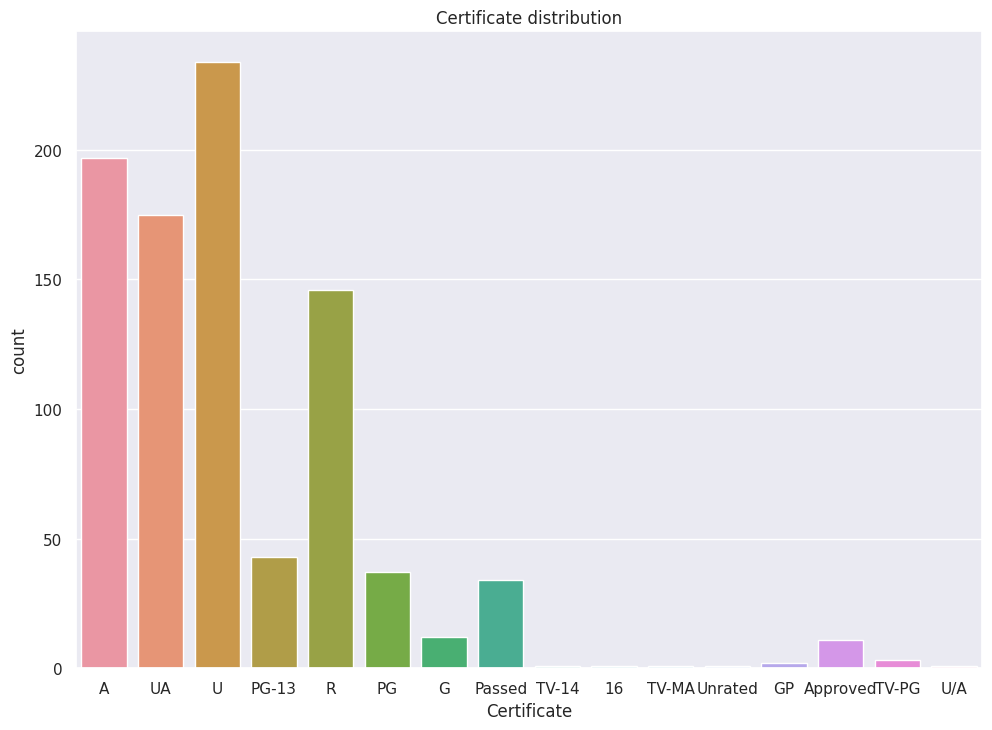

In [109]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=imdb_df,x="Certificate")
plt.title("Certificate distribution")
plt.show()

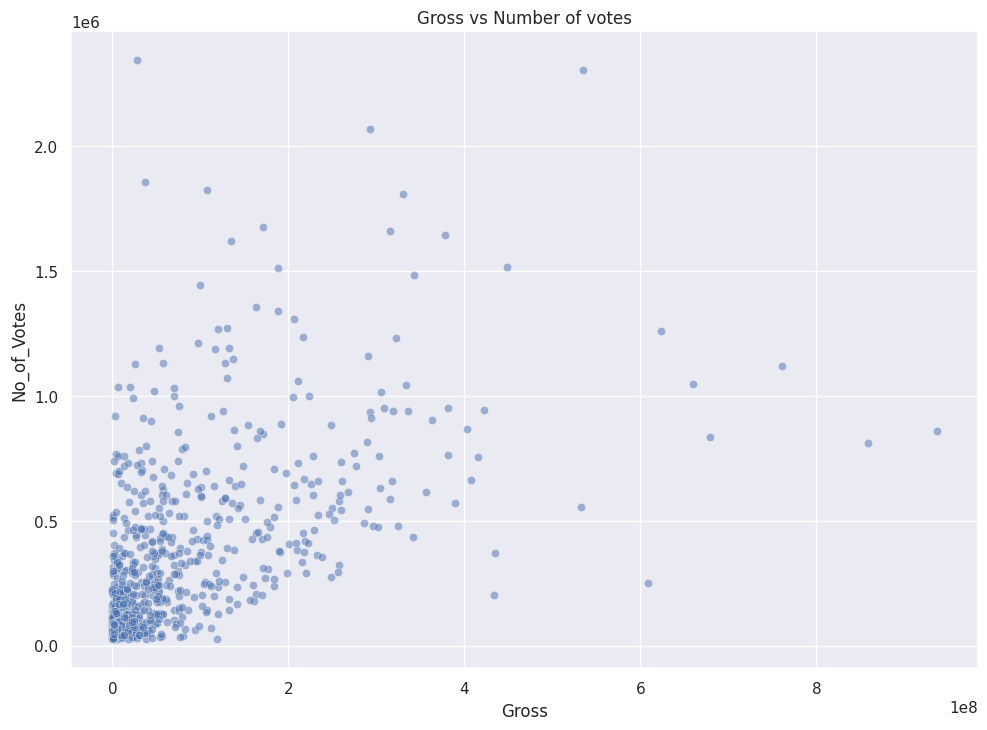

In [113]:
sns.scatterplot(data = imdb_df,x="Gross",y="No_of_Votes",alpha = 0.5)
plt.title("Gross vs Number of votes")
plt.show()

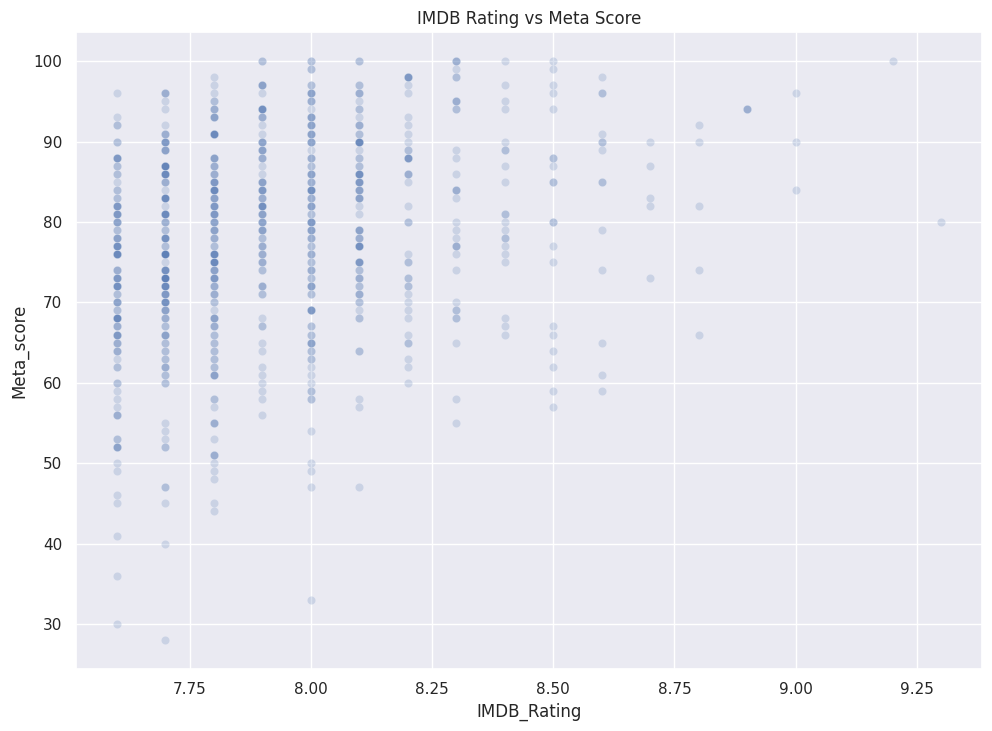

In [93]:
sns.scatterplot(data = imdb_df,x="IMDB_Rating",y="Meta_score",alpha = 0.2)
plt.title("IMDB Rating vs Meta Score")
plt.show()

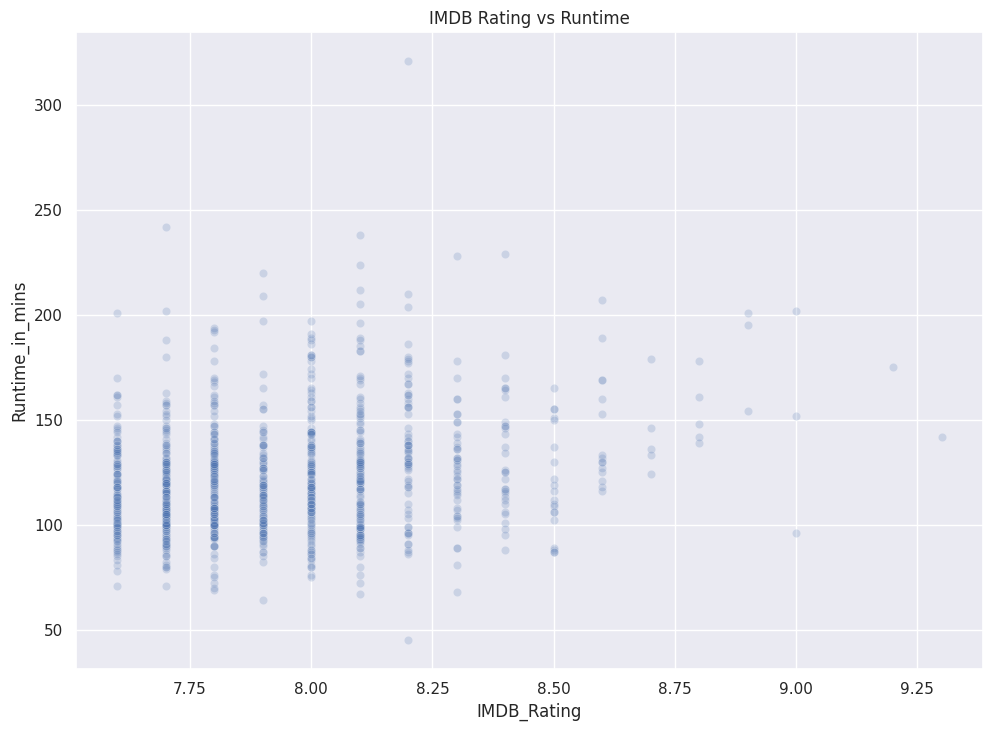

In [94]:
sns.scatterplot(data = imdb_df,x="IMDB_Rating",y="Runtime_in_mins",alpha = 0.2)
plt.title("IMDB Rating vs Runtime")
plt.show()

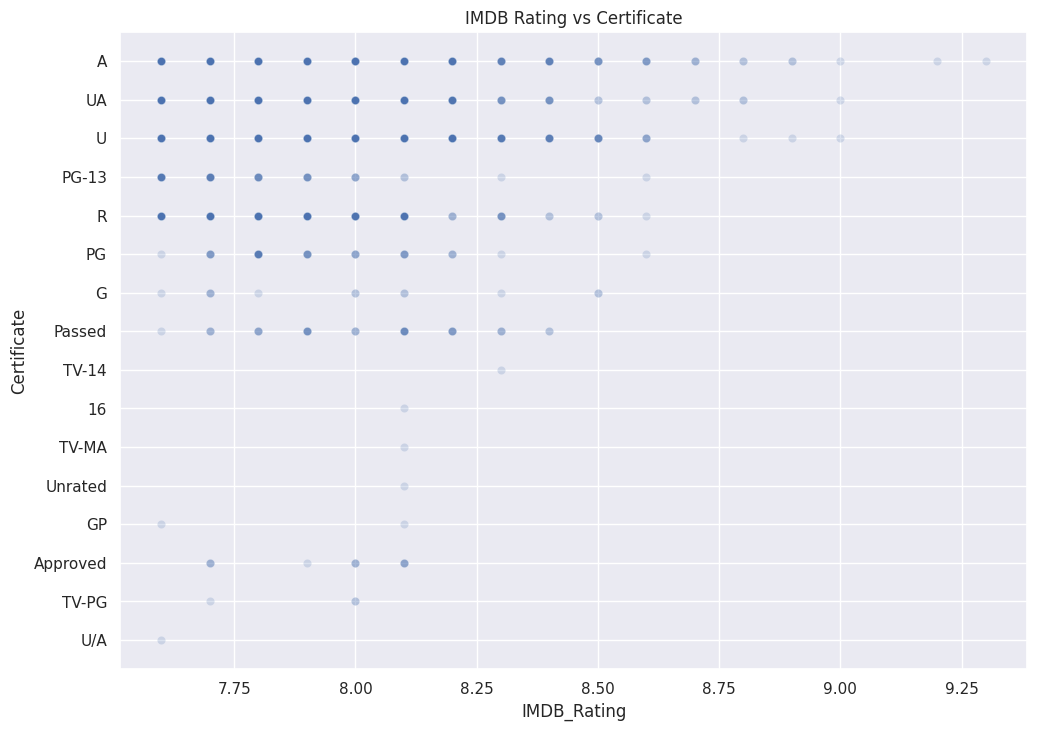

In [95]:
sns.scatterplot(data = imdb_df,x="IMDB_Rating",y="Certificate",alpha = 0.2)
plt.title("IMDB Rating vs Certificate")
plt.show()

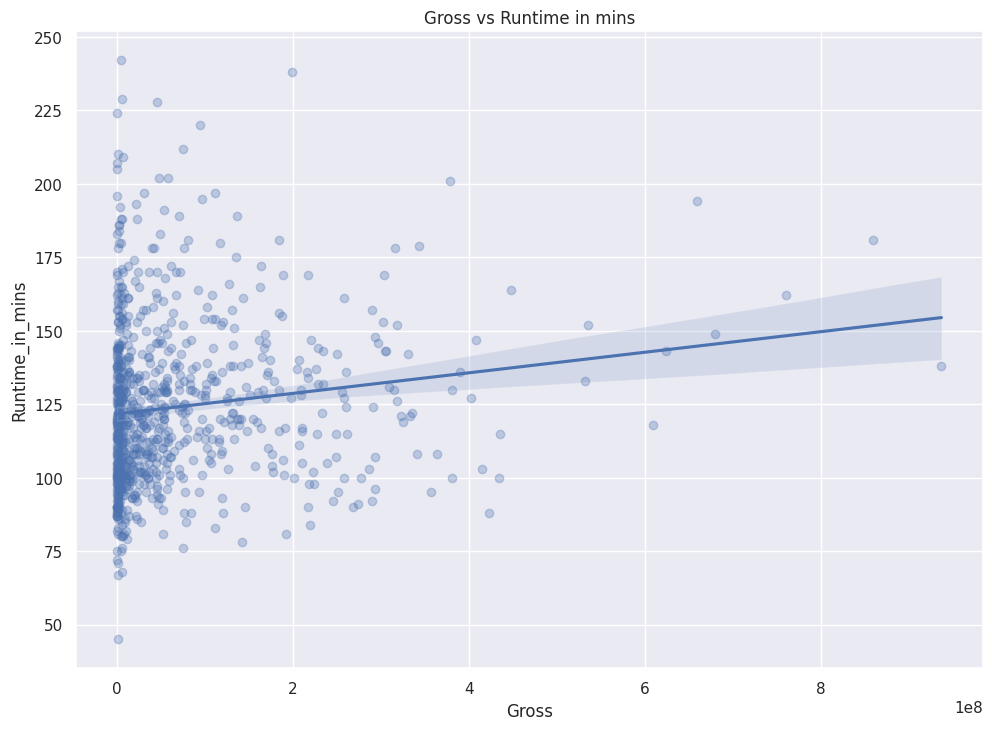

In [108]:
sns.regplot(data=imdb_df,x="Gross",y="Runtime_in_mins",scatter_kws={'alpha':0.3})
plt.title("Gross vs Runtime in mins")
plt.show()

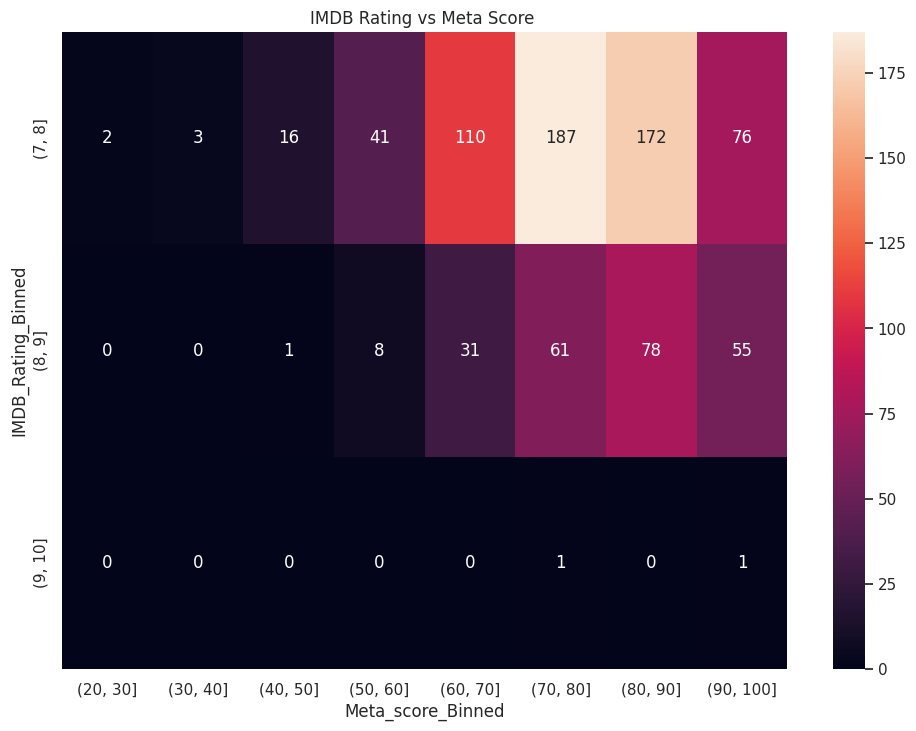

In [119]:
sns.heatmap(pd.crosstab(index=imdb_df["IMDB_Rating_Binned"],columns = imdb_df["Meta_score_Binned"]), annot=True, fmt=".0f")
plt.title("IMDB Rating vs Meta Score ")
plt.show()

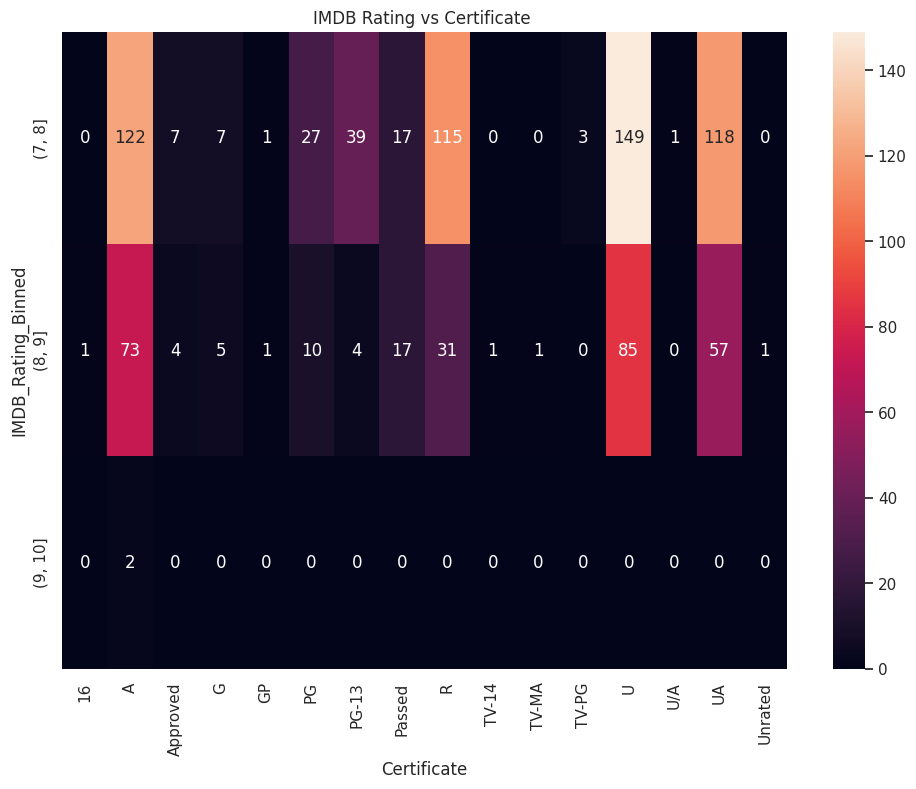

In [120]:

sns.heatmap(pd.crosstab(index=imdb_df["IMDB_Rating_Binned"],columns = imdb_df["Certificate"]), annot=True, fmt=".0f")
plt.title("IMDB Rating vs Certificate ")
plt.show()

# Story based recommendations

In [127]:
! python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [128]:
nlp = spacy.load("en_core_web_md")

In [166]:
kind_of_story = "kids"

In [170]:
%%time
doc1 = nlp(kind_of_story)

story_based_suggestions = imdb_df[["Series_Title","Overview","No_of_Votes"]]

story_based_suggestions.loc[:,"Overview_Similarity_Score"] = story_based_suggestions.apply(lambda x: doc1.similarity(nlp(x.Overview + " " + x.Series_Title)),axis=1)
story_based_suggestions.loc[:,"Series_Title_Similarity_Score"] = story_based_suggestions.apply(lambda x: doc1.similarity(nlp(x.Series_Title)),axis=1)

story_based_suggestions['Similarity_Score'] = story_based_suggestions["Overview_Similarity_Score"]  # * story_based_suggestions["Series_Title_Similarity_Score"]

<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:6: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.


CPU times: user 21.1 s, sys: 8.34 ms, total: 21.1 s
Wall time: 21.1 s


<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [172]:
story_based_suggestions.sort_values(by="Similarity_Score")[-10:]

,Series_Title,Overview,No_of_Votes,Overview_Similarity_Score,Series_Title_Similarity_Score,Similarity_Score
758,Papurika,When a machine that allows therapists to enter...,71379,0.256455,0.000000,0.256455
220,Kahaani,A pregnant woman's search for her missing husb...,57806,0.262649,-0.074164,0.262649
935,Jeux d'enfants,"As adults, best friends Julien and Sophie cont...",67360,0.264750,0.157922,0.264750
518,Mimi wo sumaseba,A love story between a girl who loves reading ...,51943,0.265263,0.167453,0.265263
170,Tonari no Totoro,When two girls move to the country to be near ...,291180,0.266286,0.204909,0.266286
56,Kimi no na wa.,Two strangers find themselves linked in a biza...,194838,0.268532,0.164088,0.268532
211,Ôkami kodomo no Ame to Yuki,After her werewolf lover unexpectedly dies in ...,38803,0.272682,0.138477,0.272682
975,When Harry Met Sally...,Harry and Sally have known each other for year...,195663,0.289978,0.205822,0.289978
886,Mustang,When five orphan girls are seen innocently pla...,35785,0.332519,-0.006468,0.332519
160,Hera Pheri,Three unemployed men look for answers to all t...,57057,0.368392,-0.050544,0.368392
